# Optimización del Modelo: Rebalanceo + Tuning

Este notebook explora cómo mejorar el rendimiento del modelo de clasificación de ictus combinando técnicas de rebalanceo de clases, algoritmos de aprendizaje automático y métodos de optimización de hiperparámetros.

In [2]:
# Carga del dataset preprocesado
import pandas as pd

# Suponemos que el archivo está en la misma carpeta que este notebook
df = pd.read_csv('cleaned_dataset.csv')

# Visualizamos las primeras filas
df.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,67.0,0,1,1,1,228.69,36.6,1,1,0,0,1,0,0
1,1,80.0,0,1,1,0,105.92,32.5,1,1,0,0,0,1,0
2,0,49.0,0,0,1,1,171.23,34.4,1,1,0,0,0,0,1
3,0,79.0,1,0,1,0,174.12,24.0,1,0,1,0,0,1,0
4,1,81.0,0,0,1,1,186.21,29.0,1,1,0,0,1,0,0


## 1. Preparación de datos
Importamos los datos ya preprocesados y realizamos la partición `train/test` (sin rebalanceo aún).

In [7]:
# Carga del dataset limpio y preprocesado
import pandas as pd
from sklearn.model_selection import train_test_split

# Definimos features y target
X = df.drop("stroke", axis=1)
y = df["stroke"]


# División train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## 2. Aplicación de técnicas de rebalanceo
Probamos varias técnicas (SMOTE, RandomUnderSampler, SMOTEENN...) y analizamos cómo afectan a la distribución de clases.

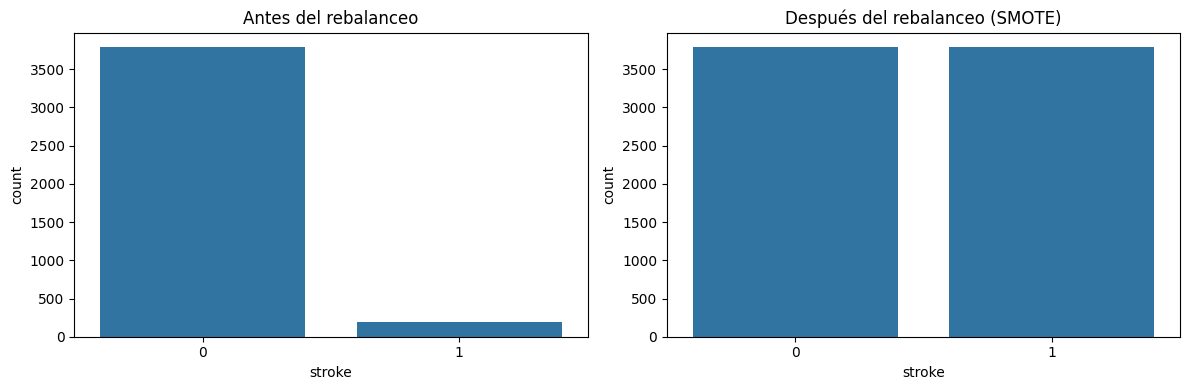

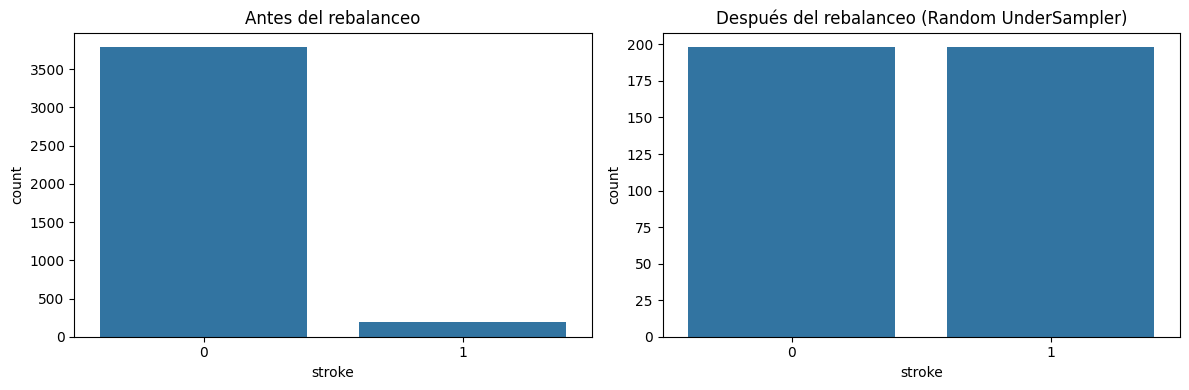

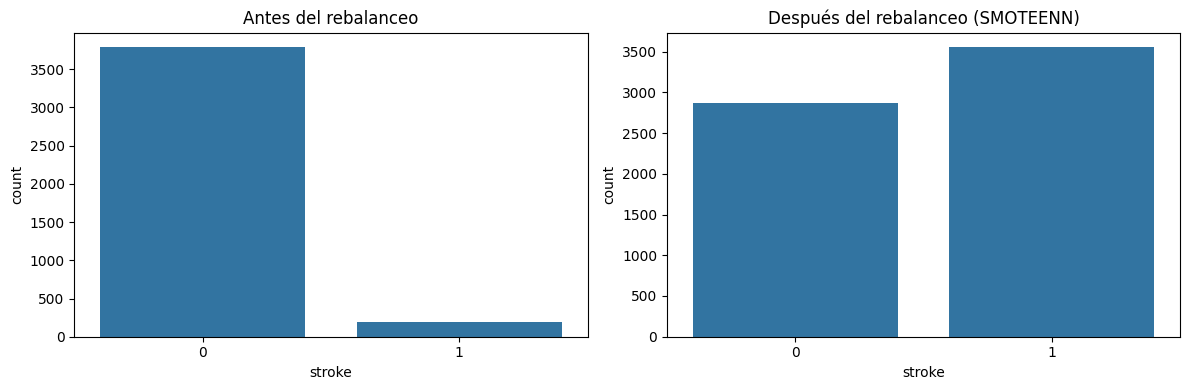

In [8]:
# Aplicación de técnicas de rebalanceo
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
import matplotlib.pyplot as plt
import seaborn as sns

# Función para mostrar la distribución de clases
def plot_class_distribution(y_original, y_resampled, title):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.countplot(x=y_original, ax=ax[0])
    ax[0].set_title('Antes del rebalanceo')
    sns.countplot(x=y_resampled, ax=ax[1])
    ax[1].set_title(f'Después del rebalanceo ({title})')
    plt.tight_layout()
    plt.show()

# SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)
plot_class_distribution(y_train, y_smote, 'SMOTE')

# RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)
plot_class_distribution(y_train, y_rus, 'Random UnderSampler')

# SMOTEENN
smoteenn = SMOTEENN(random_state=42)
X_smoteenn, y_smoteenn = smoteenn.fit_resample(X_train, y_train)
plot_class_distribution(y_train, y_smoteenn, 'SMOTEENN')

In [10]:
# Comparación de RandomForest con diferentes técnicas de rebalanceo
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Función para evaluar el modelo
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

# Entrenamiento con SMOTE
print("--- RandomForest con SMOTE ---")
rf_smote = RandomForestClassifier(random_state=42)
rf_smote.fit(X_smote, y_smote)
evaluate_model(rf_smote, X_test, y_test)

# Entrenamiento con RandomUnderSampler
print("\n--- RandomForest con RandomUnderSampler ---")
rf_rus = RandomForestClassifier(random_state=42)
rf_rus.fit(X_rus, y_rus)
evaluate_model(rf_rus, X_test, y_test)

# Entrenamiento con SMOTEENN
print("\n--- RandomForest con SMOTEENN ---")
rf_smoteenn = RandomForestClassifier(random_state=42)
rf_smoteenn.fit(X_smoteenn, y_smoteenn)
evaluate_model(rf_smoteenn, X_test, y_test)

--- RandomForest con SMOTE ---
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       947
           1       0.15      0.18      0.16        50

    accuracy                           0.91       997
   macro avg       0.55      0.56      0.56       997
weighted avg       0.92      0.91      0.91       997

ROC AUC: 0.8121

--- RandomForest con RandomUnderSampler ---
              precision    recall  f1-score   support

           0       0.99      0.70      0.82       947
           1       0.14      0.92      0.24        50

    accuracy                           0.71       997
   macro avg       0.57      0.81      0.53       997
weighted avg       0.95      0.71      0.79       997

ROC AUC: 0.8247

--- RandomForest con SMOTEENN ---
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       947
           1       0.18      0.46      0.26        50

    accuracy                           

## 3. Comparación básica de modelos con diferentes rebalanceos
Entrenamos modelos base (`RandomForest`, `XGBoost`, `LGBM`) con cada técnica y comparamos sus métricas principales.

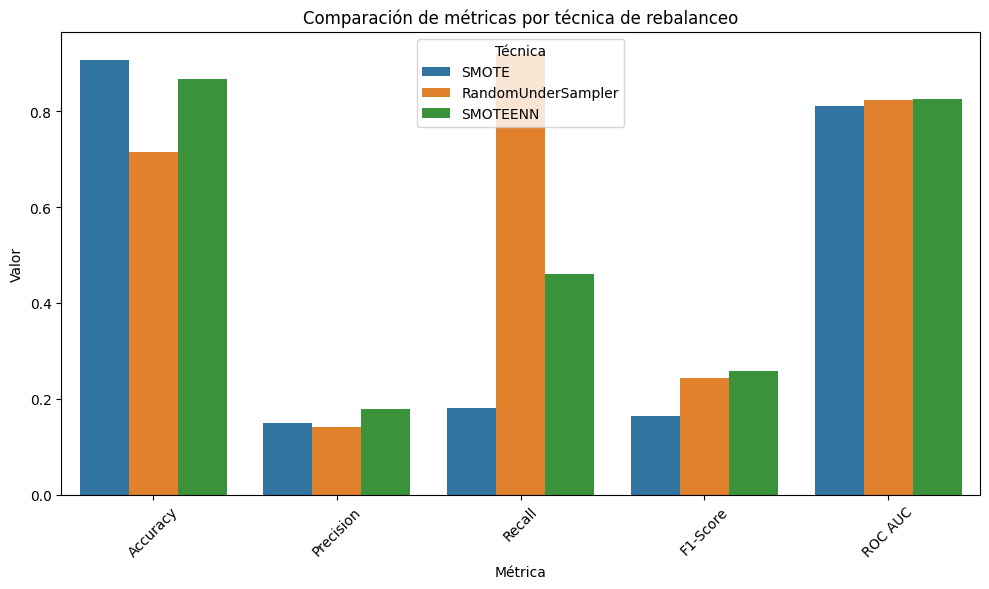

,Técnica,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,SMOTE,0.907723,0.150000,0.18,0.163636,0.812059
1,RandomUnderSampler,0.714142,0.140673,0.92,0.244032,0.824720
2,SMOTEENN,0.866600,0.178295,0.46,0.256983,0.825861


In [11]:
# Comparación visual de las métricas principales
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Función para evaluar y guardar resultados
def get_metrics(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    return {
        'Técnica': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba)
    }

# Recogemos los resultados
results = [
    get_metrics(rf_smote, X_test, y_test, 'SMOTE'),
    get_metrics(rf_rus, X_test, y_test, 'RandomUnderSampler'),
    get_metrics(rf_smoteenn, X_test, y_test, 'SMOTEENN')
]

df_results = pd.DataFrame(results)

# Visualización
plt.figure(figsize=(10, 6))
sns.barplot(data=df_results.melt(id_vars='Técnica'), x='variable', y='value', hue='Técnica')
plt.title('Comparación de métricas por técnica de rebalanceo')
plt.ylabel('Valor')
plt.xlabel('Métrica')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Mostramos la tabla también
df_results

## 4. Optimización de hiperparámetros con GridSearchCV
Aplicamos `GridSearchCV` a cada modelo y analizamos la mejora respecto al rendimiento sin tuning.

## 5. Optimización con Optuna (para modelos complejos)
Exploramos la búsqueda bayesiana de hiperparámetros para XGBoost o LightGBM usando Optuna.

## 6. Comparación final y conclusiones
Resumimos los resultados en una tabla comparativa clara y sacamos conclusiones sobre qué combinaciones funcionan mejor.